<h1>Preparation</h1>
First we need to initialize parameters and dataset. Note that all the pre defined paramters are the ones providing the
best results found yet:

<ul>
<li>datasetLocation: the path to the folder containing all the data for this training</li>
<li>normalizeY: If we want to normalize all Y positions</li>
<li>normalizeZ: If we want to normalize all Y positions</li>
<li>computeAV: If we want to add acceleration and velocity</li>
<li>linearInter: If we want to fill NaN values with linear interpolation (otherwise they are filled with zeros)</li>
</ul>

In [1]:
import ManageData
import btk as btk
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Parameters and initialize
np.random.seed(555)

datasetLocation = "Data/Participants"

normalizeY = False
normalizeZ = False
computeAV = False
linearInter = True

winSize = 500
batch_size = 500
nLSTMcells = 256
nLSTMlayers = 4
LSTMdropout = .17
FCnodes = 128
lr = 0.0001
epoch = 50

Then we want to extract all the values from the C3D files.<br><br>
All the labels that we want to extract and predict are from a text file. Each row of the file should contain one label.
Each label then gets an ID for computation purposes.
<br><br>
The trajectories comes from the corresponding data folder depending on which dataset we are working.

In [2]:
#Extract labels
labels = np.loadtxt("Data/Labels/list.txt", dtype='str')
print(str(labels.shape[0]) + " labels where extracted")
label_map = dict(zip(labels, range(0, len(labels))))

dir_list = os.listdir(datasetLocation)
c3d_files = []
for file in dir_list:
    if file.upper().endswith(".C3D"):
        c3d_files.append(datasetLocation + "/" + file)
np.random.shuffle(c3d_files)

reader = btk.btkAcquisitionFileReader()

files_problem = 0

tens_labels = []
labelledTraj = []
for file in c3d_files:
    reader.SetFilename(file)
    reader.Update()
    acq = reader.GetOutput()
    metadata = acq.GetMetaData()
    labels_list_tmp = list(metadata.FindChild("POINT").value().FindChild("LABELS").value().GetInfo().ToString())
    labels_list_tmp = [name.replace(' ', '') for name in labels_list_tmp]

    labels_list = []
    for lab in labels_list_tmp:
        if lab in labels:
            labels_list.append(lab)

    if len(labels_list) != len(labels):
        files_problem = files_problem + 1
    else:
        markers_data = [reader.GetOutput().GetPoint(marker).GetValues() for marker in labels_list]
        markers_data = np.array(markers_data)
        marker_sliced = markers_data[:,:winSize,:]
        posx = marker_sliced.T[0].T
        posy = marker_sliced.T[1].T
        posz = marker_sliced.T[2].T
        pad = winSize - posx.shape[1]
        if pad > 0:
            posx = np.pad(posx,[[0,0],[0,pad] ], 'constant')
            posy = np.pad(posy,[[0,0],[0,pad] ], 'constant')
            posz = np.pad(posz,[[0,0],[0,pad] ], 'constant')
        for j in range(len(labels_list)):
            tens_labels.append(label_map[labels_list[j]])
            posxyz = [posx[j], posy[j], posz[j]]
            posxyz = ManageData.linInterpolation(posxyz) if linearInter else np.nan_to_num(posxyz)
            labelledTraj.append(posxyz)

# mix trajs with ids
labelledTraj = np.array(labelledTraj)
shuffle_idx = np.arange(labelledTraj.shape[0])
np.random.shuffle(shuffle_idx)
labelledTraj = labelledTraj[shuffle_idx]
tens = torch.from_numpy(labelledTraj)

#creating final datasets
if normalizeY : tens = ManageData.normalizeY(tens)
if normalizeZ : tens = ManageData.normalizeZ(tens)
if computeAV : tens = ManageData.computeAV(tens)

trainingData = tens[0:15000]
testData = tens[15000:]

testData = testData.float()
testData = torch.transpose(testData,1 ,2)

tens_labels = np.array(tens_labels)
tens_labels = tens_labels[shuffle_idx]
tens_labels = torch.Tensor(tens_labels)

trainingData = trainingData.float()
trainingData = torch.transpose(trainingData,1 ,2)
features = trainingData.shape[2]

print("Shape for the training data: " + str(trainingData.shape))
print("Shape for the test data: " + str(testData.shape))

35 labels where extracted
Shape for the training data: torch.Size([15000, 500, 3])
Shape for the test data: torch.Size([3725, 500, 3])


<h1>Model</h1>
Now we initialize our model with four layers of LSTM, a Fully Connected layer, BatchNorm, ReLU, a Linear layer and a
las Fully Connected.

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(features, nLSTMcells, num_layers=nLSTMlayers, batch_first=True, bidirectional=False, dropout=LSTMdropout)
        self.fc =nn.Sequential(nn.Linear(nLSTMcells * winSize, FCnodes),
        nn.BatchNorm1d(FCnodes),
        nn.ReLU(),
        nn.Linear(FCnodes,35))

    def forward(self, x):
        res = self.lstm(x)
        return self.fc(res[0].reshape(x.shape[0], -1))

<h1>Training</h1>
The training will go along the choosed parameters. We use Adam Optimiser and a cross-entropy loss function.

Training in progress, please wait...
Best accuracy recorded: 0.6575277777777778


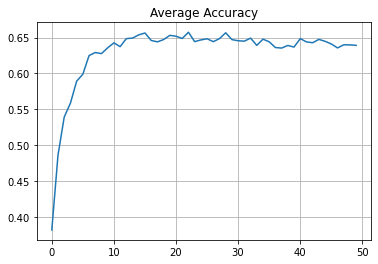

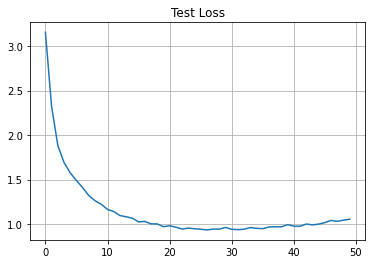

In [4]:
print('Training in progress, please wait...')
train_data = []
test_data = []
avg_hist = []
loss_hist = []
for i in range(len(trainingData)):
    train_data.append([trainingData[i], tens_labels[i]])
for i in range(len(testData)):
    test_data.append([testData[i], tens_labels[i+15000]])
train_data_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
net = LSTM().to(device)
optim = torch.optim.Adam(net.parameters(), lr=lr)
for i in range(epoch):
    net.train()
    for j, batch in enumerate(train_data_loader):
        optim.zero_grad()
        x = batch[0].to(device)
        labels = batch[1].to(device)
        pred = net(x)
        loss = F.cross_entropy(pred, labels.long())
        loss.backward()
        optim.step()
    with torch.no_grad():
        net.eval()
        avg_loss = []
        avg_acc = []
        for j, batch in enumerate(test_data_loader):
            x = batch[0].to(device)
            labels = batch[1].to(device)
            pred = net(x)
            loss = F.cross_entropy(pred, labels.long())
            acc = accuracy_score(labels.long().cpu(), torch.argmax(pred, dim=1).cpu())
            avg_loss.append(loss.item())
            avg_acc.append(acc)
        loss_hist.append(np.average(avg_loss))
        avg_hist.append(np.average(avg_acc))

print('Best accuracy recorded: ' + str(np.max(avg_hist)))
plt.title('Average Accuracy')
plt.grid(True)
plt.plot(avg_hist)

plt.figure()
plt.title('Test Loss')
plt.grid(True)
plt.plot(loss_hist)
torch.save({
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'loss': loss
            }, 'models/testedMod.txt')